In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model

# Data statistics & modeling
from scipy import stats
from model import map_setosa_knn, train_validate_test_split

# Data
import prepare
import env
import model
import acquire_telco
import split_telco

In [2]:
# Utilizing our py file function 'get_telco_data' to return our table in the form of a dataframe
df = acquire_telco.get_telco_data()
df.head()

,Unnamed: 0,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,...,payment_type_id,monthly_charges,total_charges,churn,contract_type_id.1,contract_type,payment_type_id.1,payment_type,internet_service_type_id.1,internet_service_type
0,0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,...,2,65.6,593.3,No,2,One year,2,Mailed check,1,DSL
1,1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,...,2,59.9,542.4,No,1,Month-to-month,2,Mailed check,1,DSL
2,2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,...,1,73.9,280.85,Yes,1,Month-to-month,1,Electronic check,2,Fiber optic
3,3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,...,1,98.0,1237.85,Yes,1,Month-to-month,1,Electronic check,2,Fiber optic
4,4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,...,2,83.9,267.4,Yes,1,Month-to-month,2,Mailed check,2,Fiber optic


In [3]:
# Utilizing our py file function 'prep_telco_data' to return our dataframe tidy and clean 
df = prepare.prep_telco_data(df)
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,partner_w_dependents,partner_no_dependents,dependents_no_partner,no_pod,male_w_dependents,female_w_dependents,number_relationships
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,...,0,0,1,1,0,0,0,0,0,2
1,Male,0,No,No,9,Yes,Yes,No,No,No,...,0,0,1,0,0,0,1,0,0,0
2,Male,0,No,No,4,Yes,No,No,No,Yes,...,0,1,0,0,0,0,1,0,0,0
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,...,0,1,0,0,1,0,0,0,0,1
4,Female,1,Yes,No,3,Yes,No,No,No,No,...,0,0,1,0,1,0,0,0,0,1


In [4]:
df

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,partner_w_dependents,partner_no_dependents,dependents_no_partner,no_pod,male_w_dependents,female_w_dependents,number_relationships
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,...,0,0,1,1,0,0,0,0,0,2
1,Male,0,No,No,9,Yes,Yes,No,No,No,...,0,0,1,0,0,0,1,0,0,0
2,Male,0,No,No,4,Yes,No,No,No,Yes,...,0,1,0,0,0,0,1,0,0,0
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,...,0,1,0,0,1,0,0,0,0,1
4,Female,1,Yes,No,3,Yes,No,No,No,No,...,0,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,0,No,No,13,Yes,No,Yes,No,No,...,0,0,1,0,0,0,1,0,0,0
7039,Male,0,Yes,No,22,Yes,Yes,No,No,No,...,0,1,0,0,1,0,0,0,0,1
7040,Male,0,No,No,2,Yes,No,No,Yes,No,...,0,0,1,0,0,0,1,0,0,0
7041,Male,0,Yes,Yes,67,Yes,No,Yes,No,Yes,...,0,0,1,1,0,0,0,0,0,2


In [5]:
# calling the function and applying it to our df
train, validate, test = split_telco.telco_split_explore(df)

In [6]:
train.shape, validate.shape, test.shape

((3937, 67), (1688, 67), (1407, 67))

In [7]:
train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,partner_w_dependents,partner_no_dependents,dependents_no_partner,no_pod,male_w_dependents,female_w_dependents,number_relationships
5919,Female,0,No,No,58,Yes,Yes,Yes,Yes,Yes,...,1,0,0,0,0,0,1,0,0,0
1915,Male,0,No,Yes,71,Yes,Yes,Yes,Yes,No,...,1,0,0,0,0,1,0,1,0,1
5054,Female,0,Yes,Yes,35,Yes,Yes,No internet service,No internet service,No internet service,...,0,1,0,1,0,0,0,0,0,2
2355,Male,0,Yes,Yes,1,Yes,No,No internet service,No internet service,No internet service,...,0,0,1,1,0,0,0,0,0,2
6279,Male,1,No,No,20,Yes,No,Yes,No,No,...,0,0,1,0,0,0,1,0,0,0


In [8]:
len(train)

3937

### Additional code to include in prep function later...
df.drop(columns=['phone_service', \
                 'multiple_lines', \
                 'churn', \
                 'online_security', \
                 'online_backup', \
                 'device_protection', \
                 'tech_support', \
                 'streaming_tv', \
                 'streaming_movies', \
                 'paperless_billing'], inplace=True)

df

**Note**: `payment_type_id`, `internet_service_type_id`, and `contract_type_id` are all duplicated by `payment_type`, `internet_service_type`, and `contract_type`. We can drop the id columns. `customer_id` may not be necessary either. We can drop it for now and if we end up needing it in the end for some reason, we can go back and change that.

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 5919 to 4192
Data columns (total 67 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  3937 non-null   object 
 1   senior_citizen                          3937 non-null   int64  
 2   partner                                 3937 non-null   object 
 3   dependents                              3937 non-null   object 
 4   tenure                                  3937 non-null   int64  
 5   phone_service                           3937 non-null   object 
 6   multiple_lines                          3937 non-null   object 
 7   online_security                         3937 non-null   object 
 8   online_backup                           3937 non-null   object 
 9   device_protection                       3937 non-null   object 
 10  tech_support                            3937 non-null   o

**Note**: Total charges is showing as an object value instead of a float value. Before we can visualize this in our summary process, we will need to clean this. 

The `total_charges` column contains whitespace characters. Lets see what those are connected to:

It looks like customers with zero tenure have no total charges, and this is being represented by the whitespace character. Dropping these observations for now.

In [10]:
# View numeric summary statistics
train.describe()

,senior_citizen,tenure,monthly_charges,total_charges,contract_type_id.1,payment_type_id.1,internet_service_type_id.1,gender_encoded,partner_encoded,dependents_encoded,...,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,partner_w_dependents,partner_no_dependents,dependents_no_partner,no_pod,male_w_dependents,female_w_dependents,number_relationships
count,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,...,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000,3937.000000
mean,0.161290,32.775210,64.805131,2316.775641,1.693167,2.346203,1.877826,0.498095,0.485141,0.302769,...,0.227330,0.327407,0.226314,0.250445,0.234696,0.052324,0.462535,0.031750,0.020574,0.787910
std,0.367845,24.709604,30.294804,2284.984394,0.836075,1.155924,0.740151,0.500060,0.499843,0.459514,...,0.419161,0.469327,0.418498,0.433324,0.423863,0.222708,0.498658,0.175356,0.141971,0.817415
min,0.000000,1.000000,18.250000,18.850000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,34.700000,396.100000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,30.000000,70.250000,1414.800000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,56.000000,90.300000,3893.600000,2.000000,3.000000,2.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000
max,1.000000,72.000000,118.650000,8594.400000,3.000000,4.000000,3.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


New features: Most of these are garbage and have multiple issues with keeping them - think critically about whether any of these should be used (do they actually supply new information not already represented by the existing fields?) and if they need to be one-hot encoded if kept. 

## Feature Engineering

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 5919 to 4192
Data columns (total 67 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  3937 non-null   object 
 1   senior_citizen                          3937 non-null   int64  
 2   partner                                 3937 non-null   object 
 3   dependents                              3937 non-null   object 
 4   tenure                                  3937 non-null   int64  
 5   phone_service                           3937 non-null   object 
 6   multiple_lines                          3937 non-null   object 
 7   online_security                         3937 non-null   object 
 8   online_backup                           3937 non-null   object 
 9   device_protection                       3937 non-null   object 
 10  tech_support                            3937 non-null   o

##### New columns for different family types

In [12]:
# Create New Column for is sr citizen and has fiber
df['partner&dependents'] = np.where((df['partner_encoded'] == 1) & (df['dependents_encoded'] == 1), 1, 0)

In [13]:
# Create new column: just partner, no dependents
df['partner_no_dependents'] = np.where((df['partner_encoded'] == 1) & (df['dependents_encoded'] == 0), 1, 0)

In [14]:
# Create new column: just dependents, no partner
df['dependents_no_partner'] = np.where((df['partner_encoded'] == 0) & (df['dependents_encoded'] == 1), 1, 0)

In [15]:
df['no_partner_no_dependents'] = np.where((df['partner_encoded'] == 0) & (df['dependents_encoded'] == 0), 1, 0)

In [16]:
# Create new column: single male with dependents
df['male_w_dependents'] = np.where((df['partner_encoded'] == 0) & (df['dependents_encoded'] == 1) & (df['gender_encoded'] == 0), 1, 0)

In [17]:
# Create new column: single female with dependents
df['female_w_dependents'] = np.where((df['partner_encoded'] == 0) & (df['dependents_encoded'] == 1) & (df['gender_encoded'] == 1), 1, 0)

##### New columns for electronic check

In [18]:
# electronic check columns are already encoded

##### New columns for: 

# Exploratory Analysis

In [19]:
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,payment_type_Mailed check,partner_w_dependents,partner_no_dependents,dependents_no_partner,no_pod,male_w_dependents,female_w_dependents,number_relationships,partner&dependents,no_partner_no_dependents
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,...,1,1,0,0,0,0,0,2,1,0
1,Male,0,No,No,9,Yes,Yes,No,No,No,...,1,0,0,0,1,0,0,0,0,1
2,Male,0,No,No,4,Yes,No,No,No,Yes,...,0,0,0,0,1,0,0,0,0,1
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,...,0,0,1,0,0,0,0,1,0,0
4,Female,1,Yes,No,3,Yes,No,No,No,No,...,1,0,1,0,0,0,0,1,0,0


In [20]:
df['contract_type_Month-to-month'].value_counts()

1    3875
0    3157
Name: contract_type_Month-to-month, dtype: int64

In [21]:
df['payment_type_Electronic check'].value_counts()

0    4667
1    2365
Name: payment_type_Electronic check, dtype: int64

In [22]:
df.monthly_charges.mean()

64.7982081911263

In [23]:
df.no_pod.value_counts()

0    3752
1    3280
Name: no_pod, dtype: int64

In [24]:
df.churn.value_counts()

No     5163
Yes    1869
Name: churn, dtype: int64

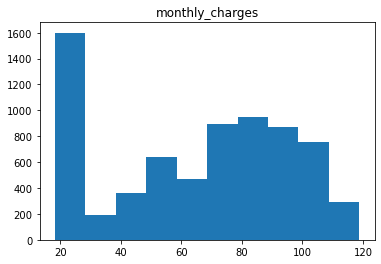

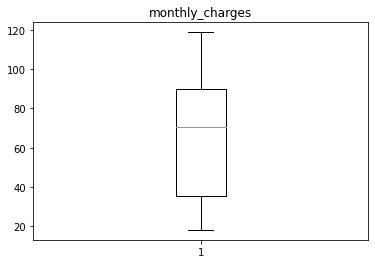

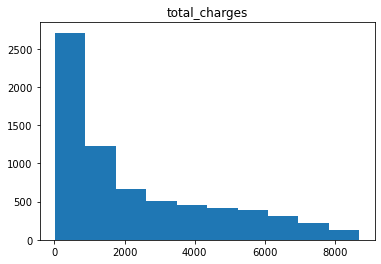

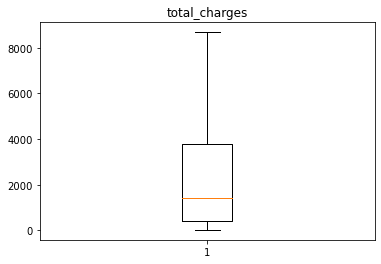

In [25]:
# Plot numeric columns
num_cols = df.columns[[df[col].dtype == 'float64' for col in df.columns]]
for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()
    plt.boxplot(df[col])
    plt.title(col)
    plt.show()

Text(0.5, 0, 'churn')

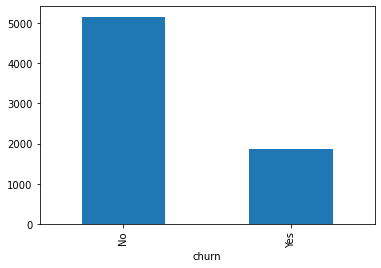

In [26]:
df.churn.value_counts().plot.bar()
plt.xlabel('churn')

In [27]:
train['contract_type_Month-to-month'].value_counts()

1    2165
0    1772
Name: contract_type_Month-to-month, dtype: int64

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 69 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  7032 non-null   object 
 1   senior_citizen                          7032 non-null   int64  
 2   partner                                 7032 non-null   object 
 3   dependents                              7032 non-null   object 
 4   tenure                                  7032 non-null   int64  
 5   phone_service                           7032 non-null   object 
 6   multiple_lines                          7032 non-null   object 
 7   online_security                         7032 non-null   object 
 8   online_backup                           7032 non-null   object 
 9   device_protection                       7032 non-null   object 
 10  tech_support                            7032 non-null   obje

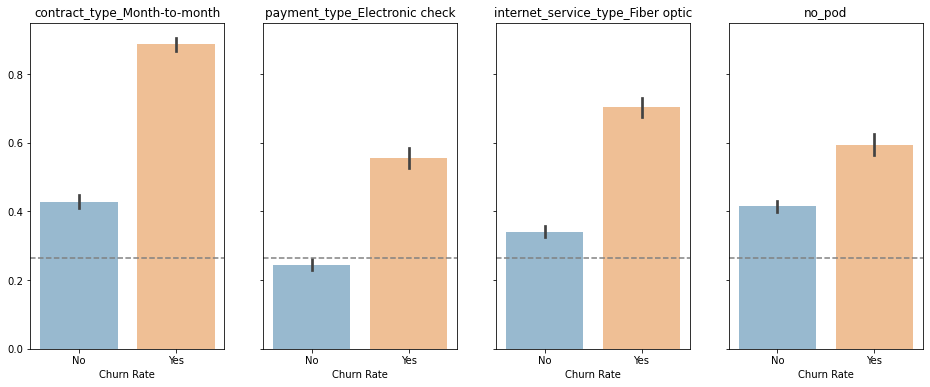

In [29]:
features = ['contract_type_Month-to-month', 'payment_type_Electronic check', 'internet_service_type_Fiber optic', 'no_pod']

enumerate(features)

list(enumerate(features))

churn_rate = train.churn_encoded.mean()
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot('churn', feature, data=train
                , ax=ax[i], alpha=0.5)
    ax[i].set_xlabel('Churn Rate')
    ax[i].set_ylabel('')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='grey')

### Exploring: M2M contract churn vs 1&2-yr contracts

### Exploring: Churn via p/d status

In [30]:
train.shape, validate.shape, test.shape

((3937, 67), (1688, 67), (1407, 67))

In [31]:
train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,partner_w_dependents,partner_no_dependents,dependents_no_partner,no_pod,male_w_dependents,female_w_dependents,number_relationships
5919,Female,0,No,No,58,Yes,Yes,Yes,Yes,Yes,...,1,0,0,0,0,0,1,0,0,0
1915,Male,0,No,Yes,71,Yes,Yes,Yes,Yes,No,...,1,0,0,0,0,1,0,1,0,1
5054,Female,0,Yes,Yes,35,Yes,Yes,No internet service,No internet service,No internet service,...,0,1,0,1,0,0,0,0,0,2
2355,Male,0,Yes,Yes,1,Yes,No,No internet service,No internet service,No internet service,...,0,0,1,1,0,0,0,0,0,2
6279,Male,1,No,No,20,Yes,No,Yes,No,No,...,0,0,1,0,0,0,1,0,0,0


Partner w/ dependents

In [32]:
pd.crosstab(train.contract_type, train.partner_w_dependents)

partner_w_dependents,0,1
contract_type,,
Month-to-month,1818,347
One year,567,248
Two year,566,391


In [33]:
pd.crosstab(train.churn, train.partner_w_dependents)

partner_w_dependents,0,1
churn,,
No,2049,842
Yes,902,144


In [34]:
# % Churn
P_w_D_Churn_Rate = 144/842
print(f'total_pop: 986')
print(f'P_w_D: {P_w_D_Churn_Rate:.2%}')

total_pop: 986
P_w_D: 17.10%


Partner, no dependents

In [35]:
pd.crosstab(train.contract_type, train.partner_no_dependents)

partner_no_dependents,0,1
contract_type,,
Month-to-month,1723,442
One year,604,211
Two year,686,271


In [36]:
pd.crosstab(train.churn, train.partner_no_dependents)

partner_no_dependents,0,1
churn,,
No,2206,685
Yes,807,239


In [37]:
P_no_D_Churn_Rate = 239/685
print(f'total_pop: 924')
print(f'P_no_D: {P_no_D_Churn_Rate:.2%}')

total_pop: 924
P_no_D: 34.89%


Dependents, no partner

In [38]:
pd.crosstab(train.contract_type, train.dependents_no_partner)

dependents_no_partner,0,1
contract_type,,
Month-to-month,2052,113
One year,767,48
Two year,912,45


In [39]:
pd.crosstab(train.churn, train.dependents_no_partner)

dependents_no_partner,0,1
churn,,
No,2727,164
Yes,1004,42


In [40]:
D_no_P_Churn_Rate = 42/164
print(f'total_pop: 206')
print(f'D_no_P: {D_no_P_Churn_Rate:.2%}')

total_pop: 206
D_no_P: 25.61%


Neither partner nor dependents (NONE)

In [41]:
pd.crosstab(train.contract_type, train.no_pod)

no_pod,0,1
contract_type,,
Month-to-month,902,1263
One year,507,308
Two year,707,250


In [42]:
pd.crosstab(train.churn, train.no_pod)

no_pod,0,1
churn,,
No,1691,1200
Yes,425,621


In [43]:
D_no_P_Churn_Rate = 621/1200
print(f'total_pop: 1821')
print(f'neither: {D_no_P_Churn_Rate:.2%}')

total_pop: 1821
neither: 51.75%


### Exploring: M2M Churn by Payment Type

In [44]:
pd.crosstab(train['contract_type_Month-to-month'], train['payment_type_Bank transfer (automatic)'])

payment_type_Bank transfer (automatic),0,1
contract_type_Month-to-month,,
0,1234,538
1,1841,324


In [45]:
pd.crosstab(train['churn'], train['payment_type_Bank transfer (automatic)'])

payment_type_Bank transfer (automatic),0,1
churn,,
No,2178,713
Yes,897,149


In [46]:
# % Churn
Bank_Tr_Churn_Rate = 149/713
print(f'total_pop: 862')
print(f'Bank_Tr_Churn_Rate: {Bank_Tr_Churn_Rate:.2%}')

total_pop: 862
Bank_Tr_Churn_Rate: 20.90%


In [47]:
pd.crosstab(train['contract_type_Month-to-month'], train['payment_type_Credit card (automatic)'])

payment_type_Credit card (automatic),0,1
contract_type_Month-to-month,,
0,1203,569
1,1839,326


In [48]:
pd.crosstab(train['churn'], train['payment_type_Credit card (automatic)'])

payment_type_Credit card (automatic),0,1
churn,,
No,2141,750
Yes,901,145


In [49]:
# % Churn
CC_Churn_Rate = 145/750
print(f'total_pop: 895')
print(f'CC_Churn_Rate: {CC_Churn_Rate:.2%}')

total_pop: 895
CC_Churn_Rate: 19.33%


In [50]:
pd.crosstab(train['contract_type_Month-to-month'], train['payment_type_Electronic check'])

payment_type_Electronic check,0,1
contract_type_Month-to-month,,
0,1491,281
1,1157,1008


In [51]:
pd.crosstab(train['churn'], train['payment_type_Electronic check'])

payment_type_Electronic check,0,1
churn,,
No,2183,708
Yes,465,581


In [52]:
# % Churn
Electronic_Check_Churn_Rate = 581/708
print(f'total_pop: 1289')
print(f'Electronic_Check_Churn_Rate: {Electronic_Check_Churn_Rate:.2%}')

total_pop: 1289
Electronic_Check_Churn_Rate: 82.06%


#### ****Electronic Check Churn Rate is VERY HIGH. Explore further!

In [53]:
pd.crosstab(train['contract_type_Month-to-month'], train['payment_type_Mailed check'])

payment_type_Mailed check,0,1
contract_type_Month-to-month,,
0,1388,384
1,1658,507


In [54]:
pd.crosstab(train['churn'], train['payment_type_Mailed check'])

payment_type_Mailed check,0,1
churn,,
No,2171,720
Yes,875,171


In [55]:
# % Churn
Mailed_Check_Churn_Rate = 171/720
print(f'total_pop: 891')
print(f'Mailed_Check_Churn_Rate: {Mailed_Check_Churn_Rate:.2%}')

total_pop: 891
Mailed_Check_Churn_Rate: 23.75%


### Exploring: (payment_type) Electronic Check - Churn

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 5919 to 4192
Data columns (total 67 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  3937 non-null   object 
 1   senior_citizen                          3937 non-null   int64  
 2   partner                                 3937 non-null   object 
 3   dependents                              3937 non-null   object 
 4   tenure                                  3937 non-null   int64  
 5   phone_service                           3937 non-null   object 
 6   multiple_lines                          3937 non-null   object 
 7   online_security                         3937 non-null   object 
 8   online_backup                           3937 non-null   object 
 9   device_protection                       3937 non-null   object 
 10  tech_support                            3937 non-null   o

In [57]:
pd.crosstab(train['payment_type_Electronic check'], train['senior_citizen'])

senior_citizen,0,1
payment_type_Electronic check,,
0,2337,311
1,965,324


In [58]:
###### ***fiber has high churn. explore further
train.groupby('payment_type_Electronic check').internet_service_type.value_counts()

payment_type_Electronic check  internet_service_type
0                              DSL                      996
                               Fiber optic              860
                               None                     792
1                              Fiber optic              862
                               DSL                      352
                               None                      75
Name: internet_service_type, dtype: int64

In [59]:
train.groupby('payment_type_Electronic check').monthly_charges.mean()

payment_type_Electronic check
0    59.340427
1    76.031303
Name: monthly_charges, dtype: float64

In [60]:
# determines that mailed_check is not worth looking at.
# assuming that mailed_check customers are mostly senior_citizens who don't affect churn considerably
train.groupby('payment_type_Mailed check').monthly_charges.mean()

payment_type_Mailed check
0    70.861556
1    44.100449
Name: monthly_charges, dtype: float64

### Exploring: (internet_service_type) Fiber vs DSL - Churn

In [61]:
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 5919 to 4192
Data columns (total 67 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  3937 non-null   object 
 1   senior_citizen                          3937 non-null   int64  
 2   partner                                 3937 non-null   object 
 3   dependents                              3937 non-null   object 
 4   tenure                                  3937 non-null   int64  
 5   phone_service                           3937 non-null   object 
 6   multiple_lines                          3937 non-null   object 
 7   online_security                         3937 non-null   object 
 8   online_backup                           3937 non-null   object 
 9   device_protection                       3937 non-null   object 
 10  tech_support                            3937 non-null   o

In [62]:
###### ***fiber has high churn. explore further
train.groupby('churn').internet_service_type.value_counts()

churn  internet_service_type
No     DSL                      1101
       Fiber optic               987
       None                      803
Yes    Fiber optic               735
       DSL                       247
       None                       64
Name: internet_service_type, dtype: int64

In [63]:
# Average monthly charge for customers with and without Fiber
train.groupby('internet_service_type_Fiber optic').monthly_charges.mean()

internet_service_type_Fiber optic
0    43.786411
1    91.841405
Name: monthly_charges, dtype: float64

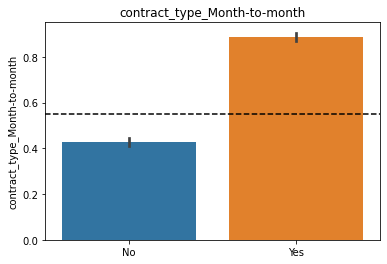

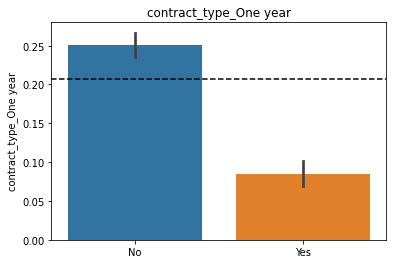

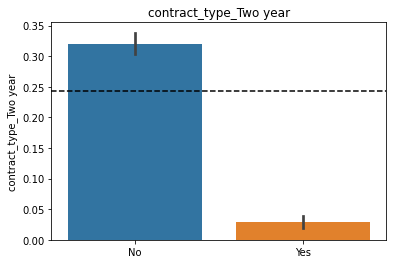

In [64]:
# Barplot expressing churn rate of customers by contract type: Month-to-Month, 1-yr, and 2-yr contracts
variables = ['contract_type_Month-to-month', 'contract_type_One year', 'contract_type_Two year']

mean = [train['contract_type_Month-to-month'].mean(), train['contract_type_One year'].mean(), train['contract_type_Two year'].mean()]

for x in range(0,3):
    sns.barplot('churn',variables[x], data=train)
    
    plt.xlabel('')
    plt.title(variables[x])
    plt.axhline(mean[x], ls = '--', color = 'black')
    plt.show()

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 5919 to 4192
Data columns (total 67 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  3937 non-null   object 
 1   senior_citizen                          3937 non-null   int64  
 2   partner                                 3937 non-null   object 
 3   dependents                              3937 non-null   object 
 4   tenure                                  3937 non-null   int64  
 5   phone_service                           3937 non-null   object 
 6   multiple_lines                          3937 non-null   object 
 7   online_security                         3937 non-null   object 
 8   online_backup                           3937 non-null   object 
 9   device_protection                       3937 non-null   object 
 10  tech_support                            3937 non-null   o

## Plots analyzing our 4 Questions

### Bivariate Analysis

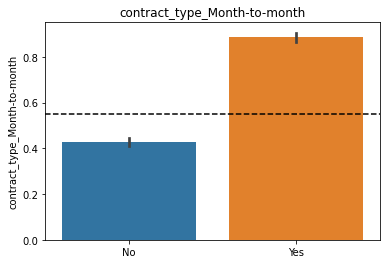

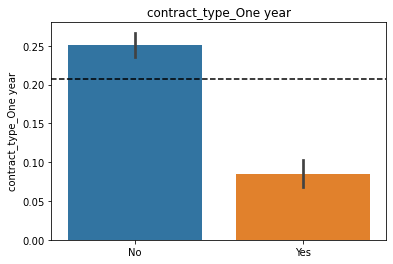

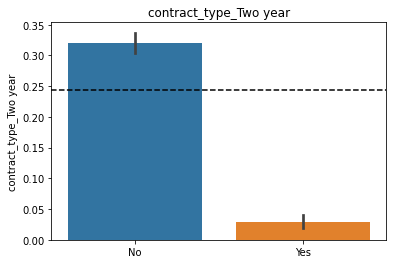

In [66]:
## Q1: M2M customer churn vs. 1-yr and 2-yr customer churn
# Barplot expressing churn rate of customers by contract type: Month-to-Month, 1-yr, and 2-yr contracts
variables = ['contract_type_Month-to-month', 'contract_type_One year', 'contract_type_Two year']

mean = [train['contract_type_Month-to-month'].mean(), train['contract_type_One year'].mean(), train['contract_type_Two year'].mean()]

for x in range(0,3):
    sns.barplot('churn',variables[x], data=train)
    
    plt.xlabel('')
    plt.title(variables[x])
    plt.axhline(mean[x], ls = '--', color = 'black')
    plt.show()

Month-to-Month: Churn is very significant for M2M customers. This indicates the need for further exploration and statistical analysis.

1-yr & 2-yr contracts also appear to be very significant.

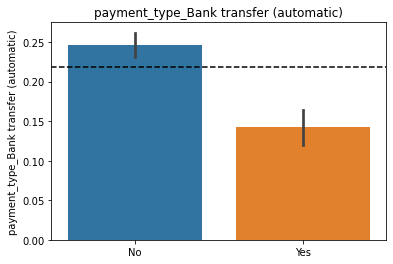

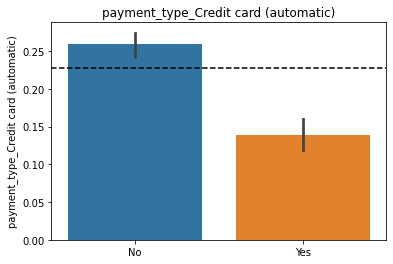

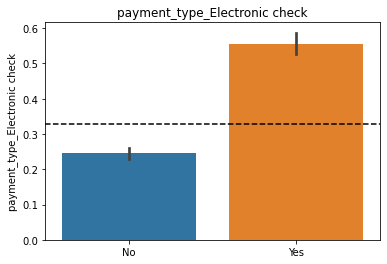

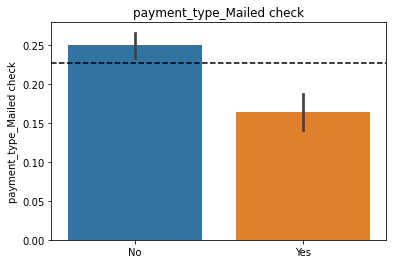

In [67]:
## Q2: Electronic Check vs. other payment types
# Barplot expressing churn rate of customers by payment type: bank transfer, cc, e-check, mailed-check
variables = ['payment_type_Bank transfer (automatic)', 'payment_type_Credit card (automatic)', 'payment_type_Electronic check', 'payment_type_Mailed check']

mean = [train['payment_type_Bank transfer (automatic)'].mean(), train['payment_type_Credit card (automatic)'].mean(), train['payment_type_Electronic check'].mean(), train['payment_type_Mailed check'].mean()]

for x in range(0,4):
    sns.barplot('churn',variables[x], data=train)
    
    plt.xlabel('')
    plt.title(variables[x])
    plt.axhline(mean[x], ls = '--', color = 'black')
    plt.show()

Comparatively, all payment types have low churn except for customers who pay by electronic check. 

I'll investigate electronic check churn further. However, since all 4 payment types are statistically significant, I'll include those in modeling as well. 

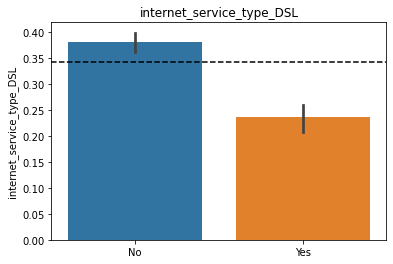

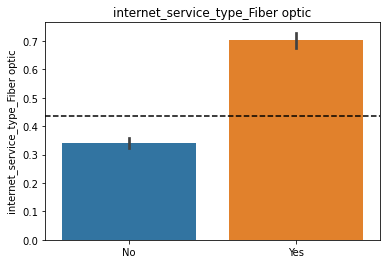

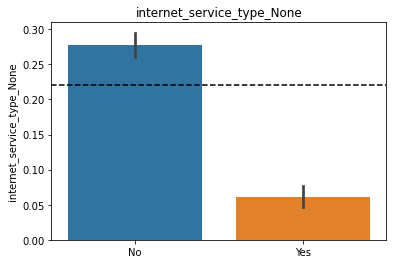

In [68]:
## Q3
# Barplot expressing churn rate of customers by internet type: Fiber, DSL, or none
variables = ['internet_service_type_DSL', 'internet_service_type_Fiber optic', 'internet_service_type_None']

mean = [train['internet_service_type_DSL'].mean(), train['internet_service_type_Fiber optic'].mean(), train['internet_service_type_None'].mean()]

for x in range(0,3):
    sns.barplot('churn',variables[x], data=train)
    
    plt.xlabel('')
    plt.title(variables[x])
    plt.axhline(mean[x], ls = '--', color = 'black')
    plt.show()

In [69]:
# Chi-squared test determining whether churn rate for customers with DSL internet is statistically significant
dsl_stat = pd.crosstab(train['internet_service_type_DSL'], train.churn_encoded)

print(dsl_stat)

a = 0.05

chi2, p, degf, expected = stats.chi2_contingency(dsl_stat)

chi2, p

print('--------------------------------------')

print(f'p: {p}')

if p < a:
    print("We reject the null hypothesis and this variable is statistically significant")
else:
    print("We fail to reject the null hypothesis and this feature is not statisitcally significant")

churn_encoded                 0    1
internet_service_type_DSL           
0                          1790  799
1                          1101  247
--------------------------------------
p: 3.983806924956342e-17
We reject the null hypothesis and this variable is statistically significant


In [70]:
# Chi-squared test determining whether churn rate for customers with Fiber internet is statistically significant
fiber_stat = pd.crosstab(train['internet_service_type_Fiber optic'], train.churn_encoded)

print(fiber_stat)

a = 0.05

chi2, p, degf, expected = stats.chi2_contingency(fiber_stat)

chi2, p

print('--------------------------------------------')

print(f'p: {p}')

if p < a:
    print("We reject the null hypothesis and this variable is statistically significant")
else:
    print("We fail to reject the null hypothesis and this feature is not statisitcally significant")

churn_encoded                         0    1
internet_service_type_Fiber optic           
0                                  1904  311
1                                   987  735
--------------------------------------------
p: 2.831419548361709e-90
We reject the null hypothesis and this variable is statistically significant


In [71]:
# Chi-squared test determining whether churn rate for customers with NO internet is statistically significant
no_net_stat = pd.crosstab(train['internet_service_type_None'], train.churn_encoded)

print(no_net_stat)

a = 0.05

chi2, p, degf, expected = stats.chi2_contingency(no_net_stat)

chi2, p

print('--------------------------------------------')

print(f'p: {p}')

if p < a:
    print("We reject the null hypothesis and this variable is statistically significant")
else:
    print("We fail to reject the null hypothesis and this feature is not statisitcally significant")

churn_encoded                  0    1
internet_service_type_None           
0                           2088  982
1                            803   64
--------------------------------------------
p: 2.8653012180661676e-47
We reject the null hypothesis and this variable is statistically significant


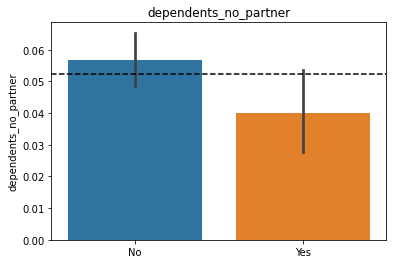

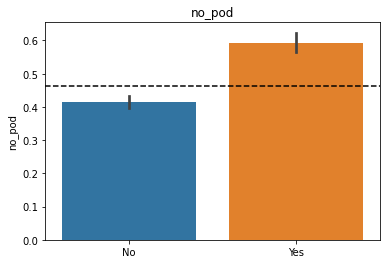

In [72]:
## Q4: Adults with dependents vs. Adults without dependents
# Barplot expressing churn rate of customers by dependent status: Single Adults no dependents vs. Single Adults with dependents
variables = ['dependents_no_partner', 'no_pod']

mean = [train['dependents_no_partner'].mean(), train['no_pod'].mean()]

for x in range(0,2):
    sns.barplot('churn',variables[x], data=train)
    
    plt.xlabel('')
    plt.title(variables[x])
    plt.axhline(mean[x], ls = '--', color = 'black')
    plt.show()

Dependents, no partner: also not statistically significant.

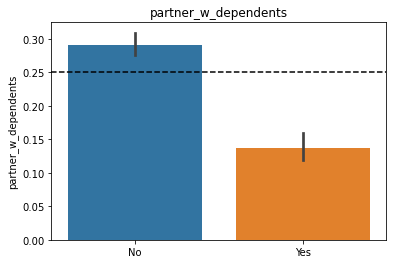

In [73]:
## Q4 (continued): comparing all against partner+dependents
# Barplot expressing churn rate of customers with partner and dependents
variables = ['partner_w_dependents']

mean = [train['partner_w_dependents'].mean()]

for x in range(0,1):
    sns.barplot('churn',variables[x], data=train)
    
    plt.xlabel('')
    plt.title(variables[x])
    plt.axhline(mean[x], ls = '--', color = 'black')
    plt.show()

partner & dependents: seems to have lowest churn of all 4 options. 

Statistically significant and a potential for anecdotal evidence suggesting dependents influence churn significantly.

### Multivariate Analysis: Significant variables and monthly charges

In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 5919 to 4192
Data columns (total 67 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gender                                  3937 non-null   object 
 1   senior_citizen                          3937 non-null   int64  
 2   partner                                 3937 non-null   object 
 3   dependents                              3937 non-null   object 
 4   tenure                                  3937 non-null   int64  
 5   phone_service                           3937 non-null   object 
 6   multiple_lines                          3937 non-null   object 
 7   online_security                         3937 non-null   object 
 8   online_backup                           3937 non-null   object 
 9   device_protection                       3937 non-null   object 
 10  tech_support                            3937 non-null   o

sns.swarmplot(x="payment_type_Electronic check", y="monthly_charges", data=train, hue="churn", palette="Set2")
plt.legend()

Electronic Check: swarm shows potential relationship between e-check churn and higher monthly charges

sns.swarmplot(x="contract_type_Month-to-month", y="monthly_charges", data=train, hue="churn", palette="Set2")
plt.legend()

M2M: similar to e-check, swarm indicates relationship between m2m churn and higher monthly charges

sns.swarmplot(x="no_pod", y="monthly_charges", data=train, hue="churn", palette="Set2")
plt.legend()

No partner, no dependents: swarm is rather inconclusive

## Statistical Analysis

### Baseline

In [75]:
train.churn_encoded.value_counts()

0    2891
1    1046
Name: churn_encoded, dtype: int64

Baseline prediction is equivalent to the ratio of not churned in our train set over the total number of values.
baseline = 2891/3937

In [76]:
train['baseline'] = 0

In [77]:
train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,payment_type_Electronic check,payment_type_Mailed check,partner_w_dependents,partner_no_dependents,dependents_no_partner,no_pod,male_w_dependents,female_w_dependents,number_relationships,baseline
5919,Female,0,No,No,58,Yes,Yes,Yes,Yes,Yes,...,0,0,0,0,0,1,0,0,0,0
1915,Male,0,No,Yes,71,Yes,Yes,Yes,Yes,No,...,0,0,0,0,1,0,1,0,1,0
5054,Female,0,Yes,Yes,35,Yes,Yes,No internet service,No internet service,No internet service,...,1,0,1,0,0,0,0,0,2,0
2355,Male,0,Yes,Yes,1,Yes,No,No internet service,No internet service,No internet service,...,0,1,1,0,0,0,0,0,2,0
6279,Male,1,No,No,20,Yes,No,Yes,No,No,...,0,1,0,0,0,1,0,0,0,0


In [78]:
(train.churn_encoded == train.baseline).mean()

0.7343154686309372

In [79]:
# Baseline Accuracy:

baseline_accuracy = (train.churn_encoded == train.baseline).mean()

print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline accuracy: 73.43%


### Confirming statistical significance

In [80]:
m2m_stat = pd.crosstab(train['contract_type_Month-to-month'], train.churn_encoded)

print(m2m_stat)

a = 0.05

chi2, p, degf, expected = stats.chi2_contingency(m2m_stat)

chi2, p


if p < a:
    print("We reject the null hypothesis and this variable is statistically significant")
else:
    print("We fail to reject the null hypothesis and this feature is not statisitcally significant")

churn_encoded                    0    1
contract_type_Month-to-month           
0                             1653  119
1                             1238  927
We reject the null hypothesis and this variable is statistically significant


In [81]:
e_check_stat = pd.crosstab(train['payment_type_Electronic check'], train.churn_encoded)

print(e_check_stat)

a = 0.05

chi2, p, degf, expected = stats.chi2_contingency(e_check_stat)

chi2, p


if p < a:
    print("We reject the null hypothesis and this variable is statistically significant")
else:
    print("We fail to reject the null hypothesis and this feature is not statisitcally significant")

churn_encoded                     0    1
payment_type_Electronic check           
0                              2183  465
1                               708  581
We reject the null hypothesis and this variable is statistically significant


In [82]:
no_pod_stat = pd.crosstab(train['no_pod'], train.churn_encoded)

print(no_pod_stat)

a = 0.05

chi2, p, degf, expected = stats.chi2_contingency(no_pod_stat)

chi2, p


if p < a:
    print("We reject the null hypothesis and this variable is statistically significant")
else:
    print("We fail to reject the null hypothesis and this feature is not statisitcally significant")

churn_encoded     0    1
no_pod                  
0              1691  425
1              1200  621
We reject the null hypothesis and this variable is statistically significant


The above chi2 tests confirm that our selected features are statistically significant.

## Modeling

In [83]:
raw_data = acquire_telco.get_telco_data()
raw_data.head()

,Unnamed: 0,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,...,payment_type_id,monthly_charges,total_charges,churn,contract_type_id.1,contract_type,payment_type_id.1,payment_type,internet_service_type_id.1,internet_service_type
0,0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,...,2,65.6,593.3,No,2,One year,2,Mailed check,1,DSL
1,1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,...,2,59.9,542.4,No,1,Month-to-month,2,Mailed check,1,DSL
2,2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,...,1,73.9,280.85,Yes,1,Month-to-month,1,Electronic check,2,Fiber optic
3,3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,...,1,98.0,1237.85,Yes,1,Month-to-month,1,Electronic check,2,Fiber optic
4,4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,...,2,83.9,267.4,Yes,1,Month-to-month,2,Mailed check,2,Fiber optic


In [84]:
df = prepare.prep_telco_data(raw_data)
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,partner_w_dependents,partner_no_dependents,dependents_no_partner,no_pod,male_w_dependents,female_w_dependents,number_relationships
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,...,0,0,1,1,0,0,0,0,0,2
1,Male,0,No,No,9,Yes,Yes,No,No,No,...,0,0,1,0,0,0,1,0,0,0
2,Male,0,No,No,4,Yes,No,No,No,Yes,...,0,1,0,0,0,0,1,0,0,0
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,...,0,1,0,0,1,0,0,0,0,1
4,Female,1,Yes,No,3,Yes,No,No,No,No,...,0,0,1,0,1,0,0,0,0,1


In [85]:
x_train, y_train, x_validate, y_validate, x_test, y_test = split_telco.telco_split_model(df)

In [86]:
x_train.head()

,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,no_pod,partner_w_dependents,dependents_no_partner,tenure
5919,0,1,0,0,1,0,0,1,0,0,1,0,0,58
1915,0,1,0,0,1,0,0,0,1,0,0,0,1,71
5054,1,0,0,0,0,1,0,0,0,1,0,1,0,35
2355,1,0,0,0,0,0,1,0,0,1,0,1,0,1
6279,0,1,0,0,0,0,1,1,0,0,1,0,0,20


### Random Forest

In [87]:
metrics = []

for i in range(2, 25):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(x_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(x_train, y_train)
    
    out_of_sample_accuracy = forest.score(x_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.762510,0.749408,0.013102
1,3,0.786894,0.769550,0.017344
2,4,0.791974,0.771919,0.020054
3,5,0.801372,0.785545,0.015827
4,6,0.805182,0.784953,0.020229
5,7,0.812294,0.777251,0.035042
6,8,0.822962,0.772512,0.050450
7,9,0.829058,0.768957,0.060100
8,10,0.844806,0.763626,0.081180
9,11,0.860300,0.755332,0.104968


### KNN

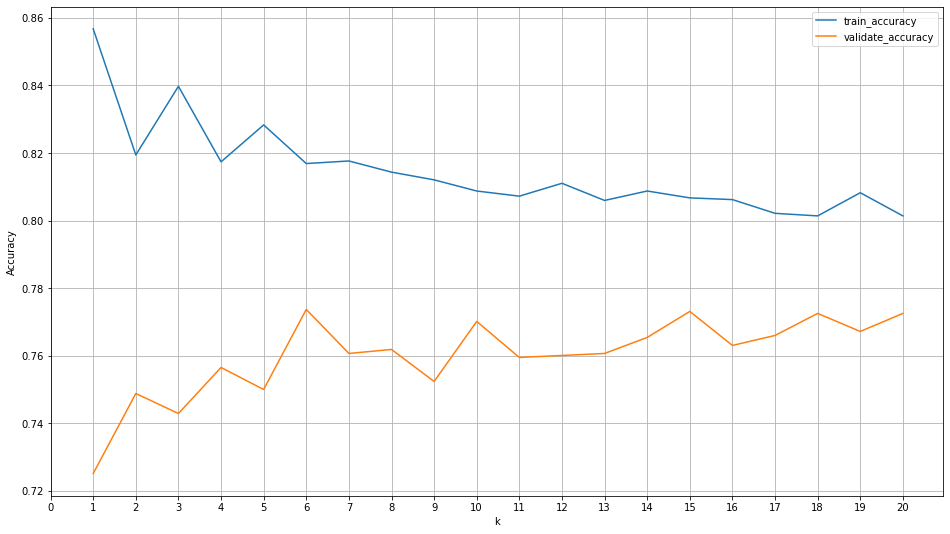

In [88]:
metrics = []

# loop through different values of k
for k in range(1, 21):
            
    # define the thing
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # fit the thing (remmeber only fit on training data)
    knn.fit(x_train, y_train)
    
    # use the thing (calculate accuracy)
    train_accuracy = knn.score(x_train, y_train)
    validate_accuracy = knn.score(x_validate, y_validate)
    
    output = {
        "k": k,
        "train_accuracy": train_accuracy,
        "validate_accuracy": validate_accuracy
    }
    
    metrics.append(output)

# make a dataframe
results = pd.DataFrame(metrics)


# plot the data
results.set_index('k').plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

In [89]:
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,k,train_accuracy,validate_accuracy,difference
0,1,0.856744,0.725118,0.131625
1,2,0.819406,0.748815,0.070590
2,3,0.839726,0.742891,0.096835
3,4,0.817374,0.756517,0.060857
4,5,0.828296,0.750000,0.078296
5,6,0.816866,0.773697,0.043169
6,7,0.817628,0.760664,0.056964
7,8,0.814326,0.761848,0.052477
8,9,0.812040,0.752370,0.059670
9,10,0.808738,0.770142,0.038595


### Logistic Regression

In [90]:
model = sklearn.linear_model.LogisticRegression(C=1)
model.fit(x_train, y_train)
accuracy = model.score(x_validate, y_validate)
coefs = dict(zip(x_train.columns, model.coef_[0]))

In [91]:
# Looping through different C values and look at resulting model coefficients

# creating a function for C
def evaluate_model(c):
    model = sklearn.linear_model.LogisticRegression(C=c)
    model.fit(x_train, y_train)
    accuracy = model.score(x_validate, y_validate)
    coefs = dict(zip(x_train.columns, model.coef_[0]))
    return {'C': c, 'accuracy': accuracy, **coefs}

# looping through different C values
models = [evaluate_model(c) for c in [.001, .01, .1, 1, 10, 100, 1000]]


(pd.DataFrame(models).round(3)
 .set_index(['C', 'accuracy'])
 .style
 .set_caption('Effect of different C values on accuracy (t=.5) and the resulting coefficients.')
 .set_precision(3)
)

,,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,no_pod,partner_w_dependents,dependents_no_partner,tenure
C,accuracy,,,,,,,,,,,,,,
0.001000,0.768000,0.117,-0.050,-0.067,-0.015,-0.021,0.125,-0.089,-0.078,0.216,-0.138,0.018,-0.043,-0.017,-0.036
0.010000,0.778000,0.428,-0.148,-0.280,-0.036,-0.064,0.315,-0.216,-0.190,0.723,-0.533,0.021,-0.140,-0.071,-0.033
0.100000,0.775000,0.691,-0.128,-0.578,-0.046,-0.095,0.314,-0.187,-0.134,1.038,-0.919,-0.031,-0.227,-0.161,-0.031
1.000000,0.772000,0.613,-0.245,-0.838,-0.162,-0.214,0.185,-0.279,-0.260,0.954,-1.164,-0.060,-0.267,-0.244,-0.031
10.000000,0.771000,0.608,-0.251,-0.870,-0.176,-0.227,0.175,-0.285,-0.267,0.946,-1.192,-0.063,-0.268,-0.261,-0.031
100.000000,0.771000,0.609,-0.252,-0.873,-0.176,-0.227,0.173,-0.286,-0.267,0.946,-1.195,-0.063,-0.268,-0.265,-0.031
1000.000000,0.771000,0.608,-0.252,-0.872,-0.176,-0.228,0.173,-0.286,-0.268,0.946,-1.195,-0.063,-0.268,-0.265,-0.031


C value of 0.01 seems to provide most accurate results.

## Addl. exploration: 

<AxesSubplot:>

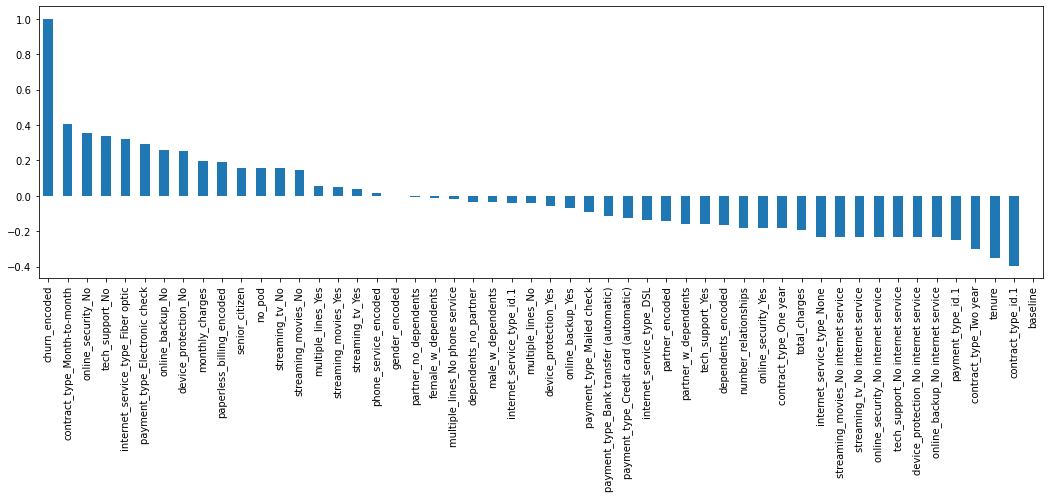

In [92]:
train.corr().churn_encoded.sort_values(ascending=False).plot(kind='bar', figsize=(18,5))